In [1]:
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

import s3fs
import cftime
import intake
import numpy as np
from pyproj import Transformer
from datetime import datetime
from dask.diagnostics import ProgressBar

%load_ext autoreload
%autoreload 2

## Dask 

### local

In [ ]:
from dask.distributed import Client
client = Client()
client

In [3]:
# To close at end of session
client.close()

## Salinity dataset

In [7]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(
    variable_id='so', source_id='UKESM1-0-LL', table_id='Omon', 
    # member_id='r2i1p1f2', 
    experiment_id='historical'
)
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MOHC,UKESM1-0-LL,historical,r6i1p1f3,Omon,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190604
1,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190627
2,CMIP,MOHC,UKESM1-0-LL,historical,r8i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190708
3,CMIP,MOHC,UKESM1-0-LL,historical,r4i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190708
4,CMIP,MOHC,UKESM1-0-LL,historical,r3i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190708
5,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190708
6,CMIP,MOHC,UKESM1-0-LL,historical,r7i1p1f3,Omon,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20191011
7,CMIP,MOHC,UKESM1-0-LL,historical,r9i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20191015
8,CMIP,MOHC,UKESM1-0-LL,historical,r17i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20191115
9,CMIP,MOHC,UKESM1-0-LL,historical,r19i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20191119


In [8]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dset = dset_dict[list(dset_dict.keys())[1]]
# .isel(lev=0).squeeze()
dset


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.Dataset>
Dimensions:             (i: 360, j: 330, lev: 75, bnds: 2, member_id: 16,
                         time: 1980, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * lev                 (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bnds            (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id           (member_id) <U9 'r6i1p1f3' 'r1i1p1f2' ... 'r5i1p1f3'
Dimensions without coordinates: bnds, vertices
Data variables:
    so                  (member_id, time, lev, j, i) float32 dask.array<chunksize=(1, 5, 75, 330, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
Attributes: (12/43)
    Conventions:             CF-1.7 CMIP-6.2
    experiment_id:           historical
    table_id:                Omon
    product:                 model-output
    parent_time_units:       days since 1850-01-01
    experiment:              all-forcing simulation of the recent past
    ...                      ...
    mip_era:                 CMIP6
    source:                  UKESM1.0-LL (2018): \naerosol: UKCA-GLOMAP-mode\...
    sub_experiment:          none
    institution_id:          MOHC
    source_id:               UKESM1-0-LL
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn

## Area variable

In [18]:
cat = col.search(
    variable_id='areacello', source_id='UKESM1-0-LL' 
)
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dataset_list = list(dset_dict.keys())
darea = dset_dict[dataset_list[0]].squeeze()
darea


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.Dataset>
Dimensions:             (j: 330, i: 360, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    member_id           <U8 'r1i1p1f2'
Dimensions without coordinates: vertices
Data variables:
    areacello           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    39600.0
    branch_time_in_parent:   39600.0
    cmor_version:            3.4.0
    ...                      ...
    variant_label:           r1i1p1f2
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/048bb3c9-4cba-4860-823b-d6aafc7b1f2e
    version_id:              v20190705
    intake_esm_varname:      ['areacello']
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.piControl.Ofx.gn

## selecting area

In [19]:
sssGS = dset.so.where(
    (dset.longitude>-10) & (dset.longitude<10) &
    (dset.latitude>70) & (dset.latitude<85), 
    drop=True)
dxdyGS = darea.areacello.where(
    (dset.longitude>-10) & (dset.longitude<10) &
    (dset.latitude>70) & (dset.latitude<85), 
    drop=True)
areaGS = dxdyGS.sum().values

sssGS.sel(time='1980-05')

<xarray.DataArray 'so' (time: 1, j: 29, i: 18)>
dask.array<getitem, shape=(1, 29, 18), dtype=float32, chunksize=(1, 29, 18), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) int32 268 269 270 271 272 273 274 ... 280 281 282 283 284 285
  * j          (j) int32 292 293 294 295 296 297 298 ... 315 316 317 318 319 320
    latitude   (j, i) float32 dask.array<chunksize=(29, 18), meta=np.ndarray>
    lev        float64 0.5058
    longitude  (j, i) float32 dask.array<chunksize=(29, 18), meta=np.ndarray>
  * time       (time) object 1980-05-16 00:00:00
    member_id  <U9 'r13i1p1f2'
Attributes:
    cell_measures:   area: areacello volume: volcello
    cell_methods:    area: mean where sea time: mean
    comment:         mo: This variable is reported using a z* coordinate syst...
    history:         2020-07-22T02:54:22Z altered by CMOR: Converted units fr...
    long_name:       Sea Water Salinity
    original_name:   mo: (variable_name: so)
    original_units:  1e-3
    standard_name:   sea_water_salinity
    units:           0.001

#### Correct longitudes for plotting

problem due to longitudes 'wrapping around' and go from -180 to +180, 
leads to issue with pcolormesh trying to make a quadrilateral with corners -180 and 180

from https://stackoverflow.com/questions/40009652/using-python-basemap-pcolormesh-with-non-monotonic-longitude-jumps


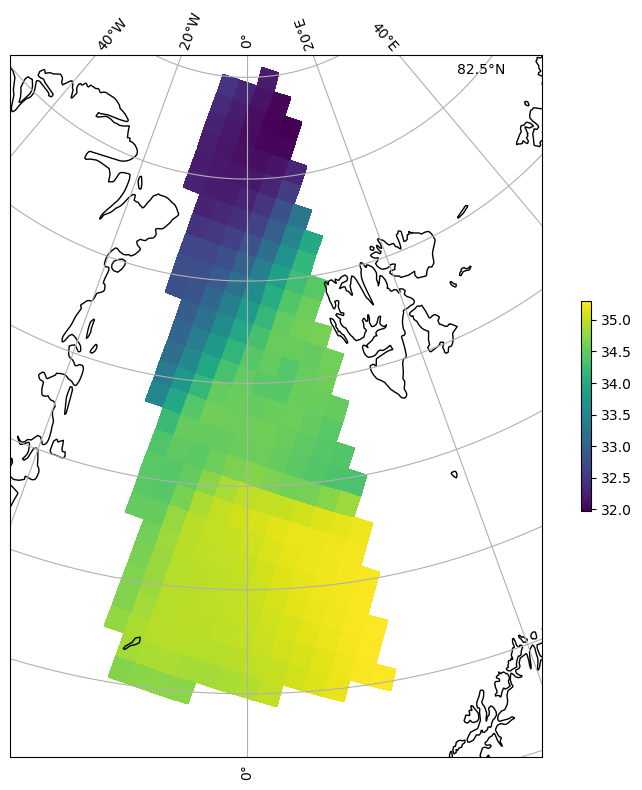

In [7]:
fig, ax = plt.subplots(figsize=(8,8),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()}
                       # subplot_kw={'projection':ccrs.PlateCarree()
                                  )

pl=ax.pcolormesh(np.unwrap(sssGS.longitude, period=360), sssGS.latitude, 
    sssGS.sel(time='1980-05').squeeze(),
    # vmin=20,vmax=35,
    transform=ccrs.PlateCarree()
    # transform=ccrs.AlbersEqualArea(),
)
fig.colorbar(pl,shrink=0.3)


ax.gridlines(draw_labels=True)
ax.coastlines()
fig.tight_layout()

## Average

In [9]:
with ProgressBar():
    sssGSmean = ((sssGS*dxdyGS).sum(dim=['i','j']) / areaGS).compute()

[########################################] | 100% Completed | 103.33 ms
[########################################] | 100% Completed | 103.57 ms
[########################################] | 100% Completed | 48.00 s


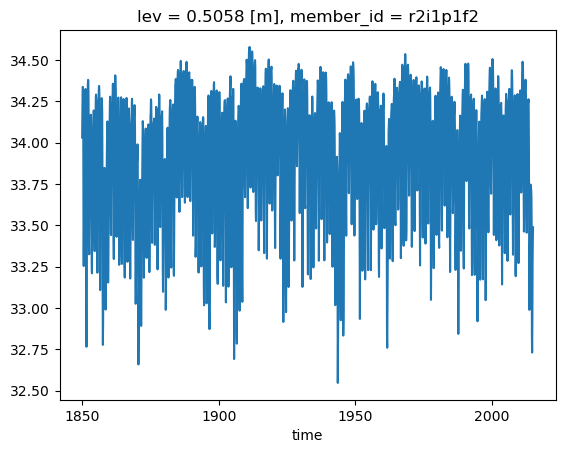

In [11]:
sssGSmean.plot()

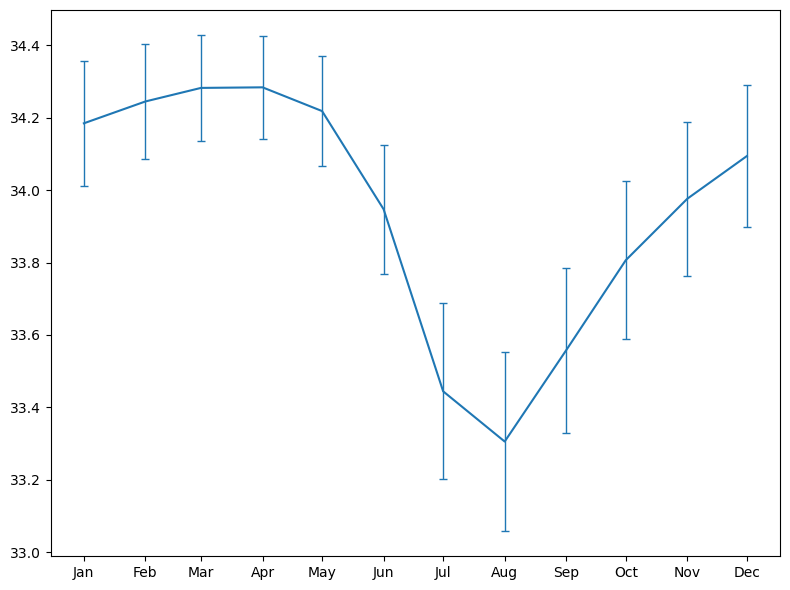

In [16]:
fig, ax = plt.subplots(figsize = (8,6))

ax.errorbar(x = [datetime.strptime(str(m).zfill(2), '%m') for m in range(1,13)],
            y = sssGSmean.groupby('time.month').mean(),
            yerr = sssGSmean.groupby('time.month').std(), capsize = 3, elinewidth = 1,
           )
fmt = mdate.DateFormatter('%b')
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_major_locator(mdate.MonthLocator())
plt.tight_layout()
